Анастасия Плавина

## Тема: Случайный лес

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import model_selection
from sklearn import datasets

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy

In [2]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, 
                                                      n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=19)


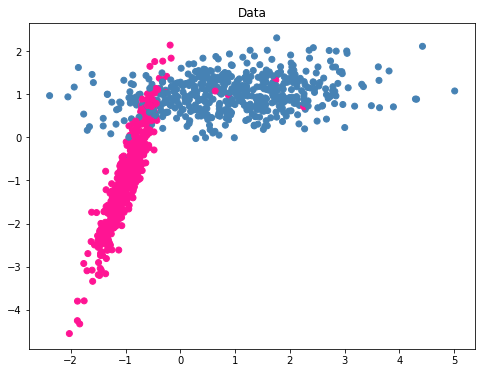

In [3]:
colors = ListedColormap(['deeppink', 'steelblue'])

plt.figure(figsize=(8,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

plt.title('Data')
plt.show()

In [4]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [5]:

random.seed(42)

def get_bootstrap(data, labels, N):
    """Создание bootstrap-выборок, по которым будут обучатья деревья
    
    returns: список выборок и словарь, сдержащий использованные и 
    не использованные индексы
    
    """
    n_samples = data.shape[0]
    bootstrap = []
    used_idx = set()
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            used_idx.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
    
    oob_idx = set(range(0, n_samples)) - used_idx

    return bootstrap, {"oob": list(oob_idx), "used": list(used_idx)}


In [6]:
# выбор признаков для выборок

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [7]:
# класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction       

In [9]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)
        
    return entropy

In [11]:
def quality(left_labels, right_labels, current_criterion, criterion_type):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if criterion_type == 'gini':
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif criterion_type == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
        

In [12]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion_type):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1
    
    if criterion_type == 'gini':
        current_criterion = gini(labels)
    elif criterion_type == 'entropy':
        current_criterion = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion_type)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion_type):

    quality, t, index = find_best_split(data, labels, criterion_type)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criterion_type)
    false_branch = build_tree(false_data, false_labels, criterion_type)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [15]:
def random_forest(data, labels, n_trees, criterion_type):
    forest = []
    bootstrap, indexes = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, criterion_type))
        
    return forest, indexes

In [16]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
light_colors = ListedColormap(['lightpink', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [21]:
tree_count = [1, 3, 10, 50, 100, 200]

Number of trees: 1


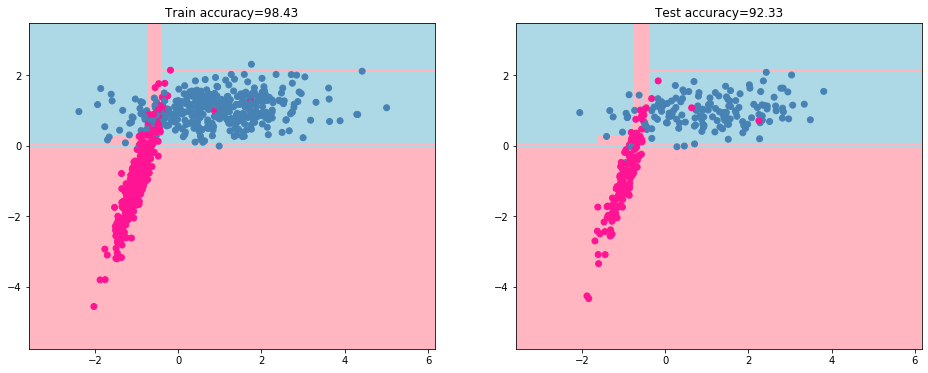

Number of trees: 3


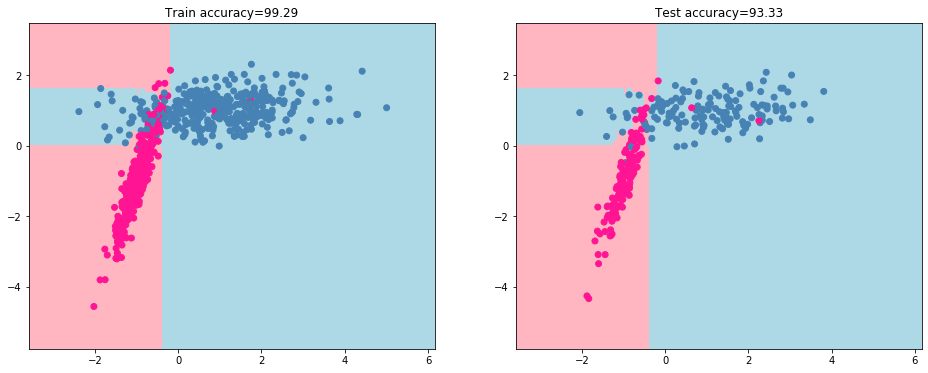

Number of trees: 10


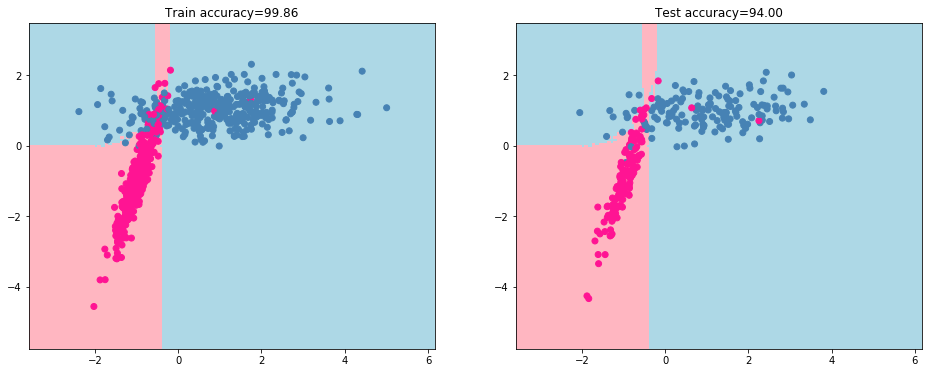

Number of trees: 50


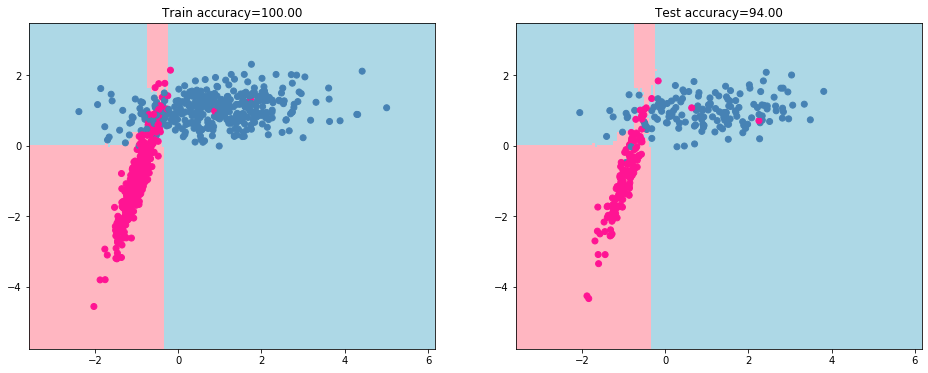

Number of trees: 100


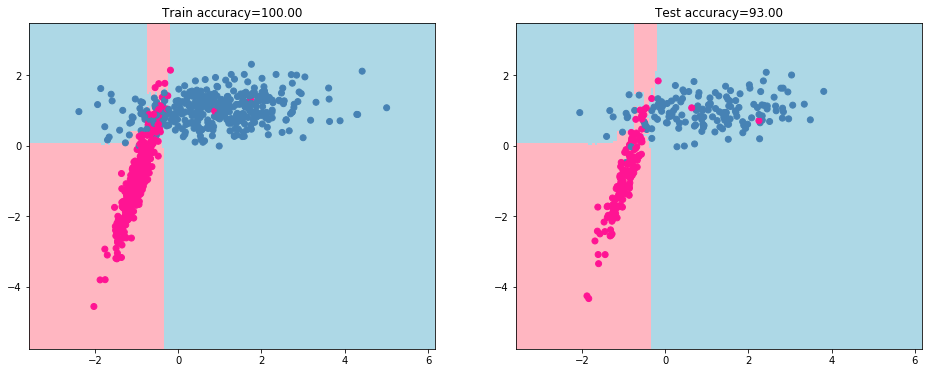

Number of trees: 200


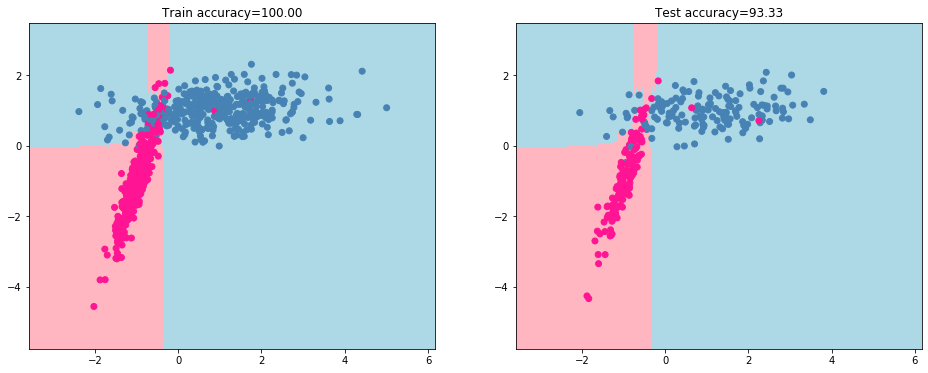

In [22]:
for n_trees in tree_count:
    my_forest, indexes = random_forest(train_data, train_labels, n_trees, criterion_type='gini')
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    print(f'Number of trees: {n_trees}')
    
    plt.figure(figsize = (16, 6))
    
    # график обучающей выборки
    plt.subplot(121)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={accuracy_metric(train_labels, train_answers):.2f}')

    # график тестовой выборки
    plt.subplot(122)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={accuracy_metric(test_labels, test_answers):.2f}')
    plt.show()

**Выводы:** Несмотря на то, что наибольшую точность на обучающей выборке мы получаем при обучении 50 деревьев, результат на тестовой выборке достигает максимума при обучении леса из 10 деревьев. Accuracy при лесе из 50 деревьев не изменяется и далее снижается при увеличении числа деревьев. Также при лесе более 10 деревьев разделяющие гиперплокости практически не меняются. Лучшие результаты достигаются при расчете качества при помощи индекса Джини.

In [23]:
tree_count = [1, 3, 4, 5]

Number of trees: 1


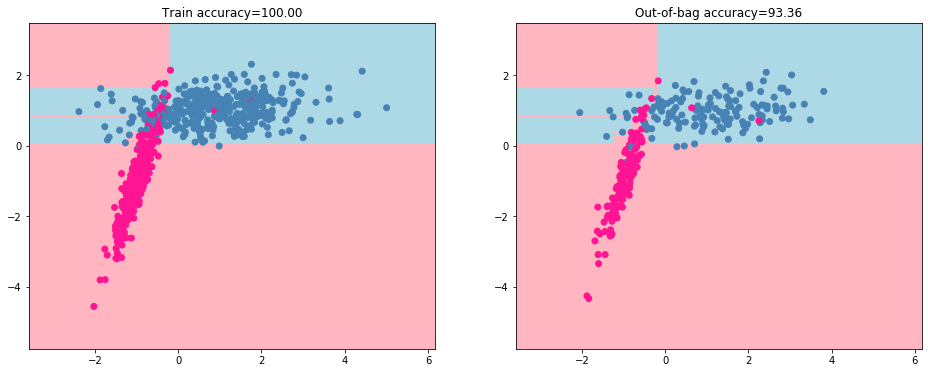

Number of trees: 3


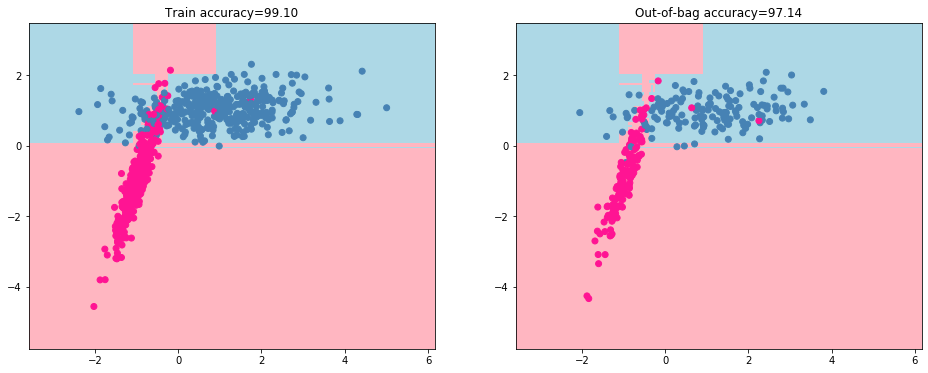

Number of trees: 4


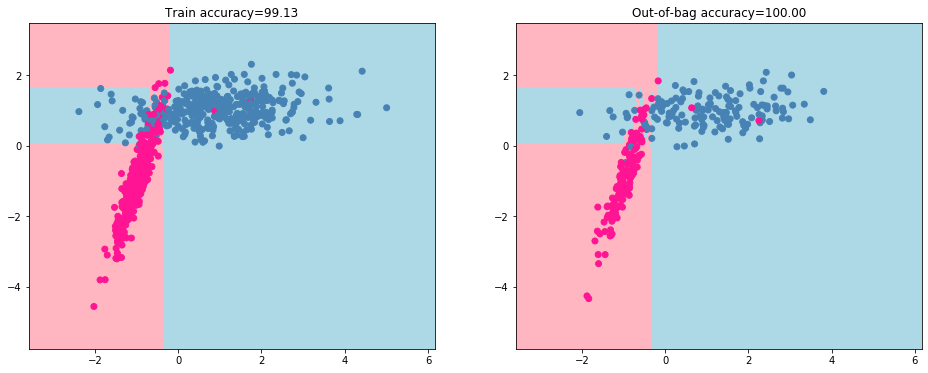

Number of trees: 5


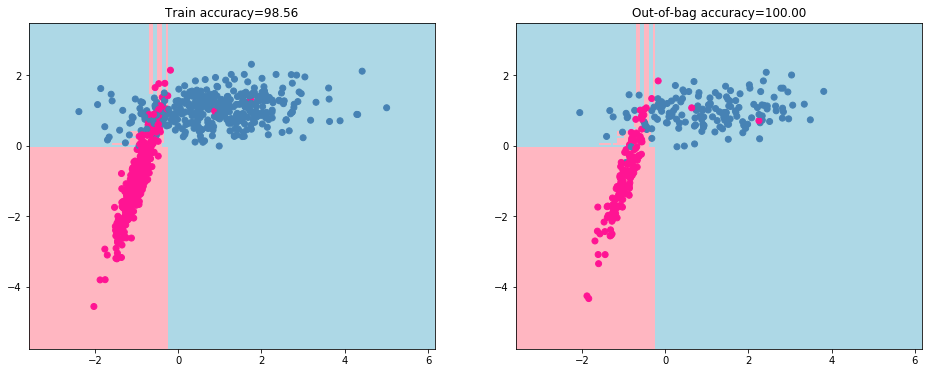

In [24]:
for n_trees in tree_count:
    my_forest, indexes = random_forest(train_data, train_labels, n_trees, criterion_type='entropy')
    
    real_train_data = np.take(train_data, indexes['used'], axis=0)
    real_train_labels = np.take(train_labels, indexes['used'], axis=0)
    
    oob_data = np.take(train_data, indexes['oob'], axis=0)
    oob_labels = np.take(train_labels, indexes['oob'], axis=0)
    
    real_train_answers = tree_vote(my_forest, real_train_data)
    oob_answers = tree_vote(my_forest, oob_data)
    
    print(f'Number of trees: {n_trees}')
    plt.figure(figsize = (16, 6))
    
    
    # график обучающей выборки без oob
    plt.subplot(121)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={accuracy_metric(real_train_labels, real_train_answers):.2f}')

    # график oob выборки
    plt.subplot(122)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Out-of-bag accuracy={accuracy_metric(oob_labels, oob_answers):.2f}')
    plt.show()

**Выводы:** При помощи проверки на out-of-bag выборке мы получаем большую точность предсказания уже на лесе из 3 деревьев и маскимальную точность в 100% на лесе из 4 деревьев. Критерии Джини и энтропия Шеннона дают одинаково хорошее качество предсказания.